# Practice on Natural Language Processing

## 라이브러리 설치

In [ ]:
import numpy as np
import pandas as pd
import math
from collections import defaultdict
from tqdm import tqdm
import re

import pickle
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.parsing.preprocessing import remove_stopwords

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils import np_utils

## 데이터 로드 및 전처리

In [ ]:
import os
from google.colab import drive


# drive.mount('/content/drive')
# assert os.path.isfile('./MyDrive/nlp/News_Category_Dataset_v2.json')

# # load data
# df = pd.read_json('./MyDrive/News_Category_Dataset_v2.json', lines=True)

df = pd.read_json('https://raw.githubusercontent.com/SoyeonHH/nlp/main/News_Category_Dataset_v2.json', lines=True)
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [ ]:
cates = df.groupby('category')
print("total categories:", cates.ngroups)
print(cates.size())

total categories: 41
category
ARTS               1509
ARTS & CULTURE     1339
BLACK VOICES       4528
BUSINESS           5937
COLLEGE            1144
COMEDY             5175
CRIME              3405
CULTURE & ARTS     1030
DIVORCE            3426
EDUCATION          1004
ENTERTAINMENT     16058
ENVIRONMENT        1323
FIFTY              1401
FOOD & DRINK       6226
GOOD NEWS          1398
GREEN              2622
HEALTHY LIVING     6694
HOME & LIVING      4195
IMPACT             3459
LATINO VOICES      1129
MEDIA              2815
MONEY              1707
PARENTING          8677
PARENTS            3955
POLITICS          32739
QUEER VOICES       6314
RELIGION           2556
SCIENCE            2178
SPORTS             4884
STYLE              2254
STYLE & BEAUTY     9649
TASTE              2096
TECH               2082
THE WORLDPOST      3664
TRAVEL             9887
WEDDINGS           3651
WEIRD NEWS         2670
WELLNESS          17827
WOMEN              3490
WORLD NEWS         2177
WORLDPOST 

In [ ]:
# as shown above, THE WORLDPOST and WORLDPOST should be the same category, so merge them.
df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

# using headlines and short_description as input X
df['text'] = df.headline + " " + df.short_description
df = df.drop(['headline', 'short_description'], axis=1)

df.head()

,category,authors,link,date,text
0,CRIME,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...
1,ENTERTAINMENT,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...
3,ENTERTAINMENT,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...


In [ ]:
# make corpus

def make_corpus():

  cates = df.groupby('category')
  cate2docs = defaultdict(list)
  list_cate = list(cates.size().to_dict().keys())

  for cate in list_cate:
      df_cate = df[df['category'] == cate]

      for idx, text in enumerate(df_cate['text'].values.tolist()):
        text = text.lower()
        text = re.sub("[^A-Za-z ]", "", text)
        # text_without_sw = remove_stopwords(text)

        cate2docs[cate].append(text)
  return list_cate, cate2docs

list_cate, cate2docs = make_corpus()

In [ ]:
# split data

def splitdata(cate2docs, split_ratio):
  train = test = defaultdict(list)

  for cate in cate2docs:
    idx_train = int(len(cate2docs[cate]) * split_ratio)
    docs_train = cate2docs[cate][:idx_train]
    docs_test = cate2docs[cate][idx_train:]

    train[cate] = docs_train
    test[cate] = docs_test

  return train, test

cate2docs_train, cate2docs_test = splitdata(cate2docs, 0.9)

# Naive Bayes

d: Document
c: class

P(c|d) = P(d|c) P(c) / P(d)

C_MAP = argmax P(d|c) P(c)
        argmax P(x1, ... xn|c) P(c)

In [ ]:
# Compute Prior
# P(c)

def prior(list_cate, cate2docs):

  num_docs = 0
  cate2freq = defaultdict(int)

  for cate in list_cate:
    freq = len(cate2docs[cate])
    cate2freq[cate] = freq
    num_docs += freq
  
  cate2prior = dict()
  for cate in list_cate:
    prior = float(cate2freq[cate]) / float(num_docs)
    cate2prior[cate] = prior
  
  return cate2prior

cate2prior = prior(list_cate, cate2docs_train)
for cate in list_cate:
  print('{:10}\t{:.4f}'.format(cate, cate2prior[cate]))

ARTS      	0.0075
ARTS & CULTURE	0.0067
BLACK VOICES	0.0225
BUSINESS  	0.0296
COLLEGE   	0.0057
COMEDY    	0.0258
CRIME     	0.0170
CULTURE & ARTS	0.0051
DIVORCE   	0.0171
EDUCATION 	0.0050
ENTERTAINMENT	0.0799
ENVIRONMENT	0.0066
FIFTY     	0.0070
FOOD & DRINK	0.0310
GOOD NEWS 	0.0070
GREEN     	0.0131
HEALTHY LIVING	0.0333
HOME & LIVING	0.0209
IMPACT    	0.0172
LATINO VOICES	0.0056
MEDIA     	0.0140
MONEY     	0.0085
PARENTING 	0.0432
PARENTS   	0.0197
POLITICS  	0.1629
QUEER VOICES	0.0314
RELIGION  	0.0127
SCIENCE   	0.0108
SPORTS    	0.0243
STYLE     	0.0112
STYLE & BEAUTY	0.0480
TASTE     	0.0104
TECH      	0.0104
TRAVEL    	0.0492
WEDDINGS  	0.0182
WEIRD NEWS	0.0133
WELLNESS  	0.0887
WOMEN     	0.0174
WORLD NEWS	0.0108
WORLDPOST 	0.0311


In [ ]:
# Compute likelihood

import math

# initialize
cate2word2freq = dict()
cate2word_freq_all = defaultdict(int)
for cate in list_cate:
    cate2word2freq[cate] = defaultdict(int)
    
set_words_all = set()    
for cate in cate2docs_train:
    for d in cate2docs_train[cate]:
        for word in d.split():
            cate2word2freq[cate][word] += 1
            cate2word_freq_all[cate] += 1
            set_words_all.add(word)
          
# in every category, compute P(w_i|c_j)
# P(w_i|c_j) = word w_i freq. in category c_j / (sum of all word freq. in category c_j) 

def likelihood(list_cate, sample_document, set_keywords=None):

  cate2likelihood = dict()

  for cate in list_cate:
    cate2likelihood[cate] = 1.0

  for word in sample_document.split():
    #filtering keywords
    if set_keywords:
      if word not in set_keywords:
        continue

    str = '\t{:15}: '.format(word)
    for cate in list_cate:
        # add-1 smoothing
        Prob_word_given_cate = math.log((cate2word2freq[cate][word] + 1) / (cate2word_freq_all[cate] + len(cate2word2freq[cate])))
        str += '{:8.4f}{:7}'.format(Prob_word_given_cate, ' ')
        cate2likelihood[cate] += Prob_word_given_cate
    print(str)
  
  return cate2likelihood

# predict
# get sample

sample_cate = list_cate[0]
d = cate2docs_test[sample_cate][0]
print(sample_cate + '\n')

print(d)
str = '\n\t{:17}'.format(' ')
for cate in list_cate:
    str += '{:15}'.format(cate)
print(str)
print('--------------------------------------------------------------------------------------------------')

cate2likelihood = likelihood(list_cate, d)

print('--------------------------------------------------------------------------------------------------')

str = '{:25}'.format('!! log(LIKELIHOOD) !! :')
for cate in list_cate:
    str += ('{:10.4f}{:5}'.format(cate2likelihood[cate], ' '))
print(str)

str = '{:25}'.format('!! log(PRIOR) !! :')
for cate in list_cate:
    str += ('{:10.4f}{:5}'.format(math.log(cate2prior[cate]), ' '))
print(str)

str = '{:25}'.format('!! SUM !! :')
for cate in list_cate:
    str += ('{:10.4f}{:5}'.format(cate2likelihood[cate] + math.log(cate2prior[cate]), ' '))
print(str)

# predict result
cate2pred = dict()
for cate in list_cate:
  cate2pred[cate] = cate2likelihood[cate] + math.log(cate2prior[cate])
print('\n Predicted Class: ', sorted(list(cate2pred.items()), key = lambda x : x[1], reverse=True)[0])

ARTS

comedy tonight a popular show business axiom insists that dying is easy comedy is hard while any performer who has bombed onstage will quickly acknowledge this bitter truth the bottom line is that comedy depends on good ideas and solid execution

	                 ARTS           ARTS & CULTURE BLACK VOICES   BUSINESS       COLLEGE        COMEDY         CRIME          CULTURE & ARTS DIVORCE        EDUCATION      ENTERTAINMENT  ENVIRONMENT    FIFTY          FOOD & DRINK   GOOD NEWS      GREEN          HEALTHY LIVING HOME & LIVING  IMPACT         LATINO VOICES  MEDIA          MONEY          PARENTING      PARENTS        POLITICS       QUEER VOICES   RELIGION       SCIENCE        SPORTS         STYLE          STYLE & BEAUTY TASTE          TECH           TRAVEL         WEDDINGS       WEIRD NEWS     WELLNESS       WOMEN          WORLD NEWS     WORLDPOST      
--------------------------------------------------------------------------------------------------
	comedy         :  -7.3182   

In [ ]:
# considering important words (TF-IDF)

# TF = cate2word2freq

# IDF = 1 / Document frequencty

topk = 100

word2idf = dict()
for word in set_words_all:
    doc_freq = 0
    for cate in list_cate:
        if word in cate2word2freq[cate]:
            doc_freq += 1
    idf = len(list_cate) + 1 / doc_freq
    word2idf[word] = idf

import collections

# get top-k (100) important words in each category
set_keywords = set()
cate2keywords = defaultdict(list)
word2tf_idf = dict()
for i in range(len(list_cate)):
    cate = list_cate[i]
    for word, tf in cate2word2freq[cate].items():
        tf_idf = tf * word2idf[word]
        word2tf_idf[word] = tf_idf
    od_word2tf_idf = collections.OrderedDict(sorted(word2tf_idf.items(), key=lambda x : -x[1]))
    cate2keywords[cate] = (list(od_word2tf_idf.keys())[:topk])
    if i < 3:
        print('#{}: {}'.format(cate, cate2keywords[cate]))
    set_keywords.update(cate2keywords[cate])
print("----------------------------------------------------------------------------")
print(set_keywords)

#ARTS: ['the', 'of', 'and', 'to', 'in', 'a', 'is', 'for', 'that', 'at', 'art', 'i', 'it', 'are', 'with', 'by', 'on', 'you', 'an', 'be', 'as', 'has', 'this', 'artists', 'about', 'what', 'its', 'my', 'one', 'so', 'was', 'these', 'which', 'me', 'who', 'out', 'new', 'first', 'but', 'will', 'not', 'there', 'more', 'world', 'all', 'from', 'or', 'theatre', 'cannes', 'two', 'few', 'than', 'show', 'if', 'been', 'their', 'have', 'arts', 'film', 'just', 'up', 'great', 'his', 'years', 'your', 'when', 'can', 'after', 'broadway', 'la', 'artist', 'music', 'something', 'her', 'other', 'year', 'into', 'how', 'like', 'photography', 'theater', 'works', 'play', 's', 'photos', 'he', 'back', 'long', 'some', 'may', 'make', 'why', 'nighter', 'gallery', 'festival', 'view', 'international', 'feeling', 'street', 'during']
#ARTS & CULTURE: ['the', 'a', 'to', 'of', 'in', 'and', 'you', 'with', 'is', 'for', 'this', 'art', 'your', 'are', 'an', 'its', 'it', 'not', 'more', 'what', 'all', 'that', 'on', 'new', 'one', 'ar

In [ ]:
# predict
# using top-k keywords

sample_cate = list_cate[0]
d = cate2docs_test[sample_cate][0]
print(sample_cate + '\n')

print(d)
str = '\n\t{:17}'.format(' ')
for cate in list_cate:
    str += '{:15}'.format(cate)
print(str)
print('--------------------------------------------------------------------------------------------------')

cate2likelihood = likelihood(list_cate, d, set_keywords)

print('--------------------------------------------------------------------------------------------------')

str = '{:25}'.format('!! log(LIKELIHOOD) !! :')
for cate in list_cate:
    str += ('{:10.4f}{:5}'.format(cate2likelihood[cate], ' '))
print(str)

str = '{:25}'.format('!! log(PRIOR) !! :')
for cate in list_cate:
    str += ('{:10.4f}{:5}'.format(math.log(cate2prior[cate]), ' '))
print(str)

str = '{:25}'.format('!! SUM !! :')
for cate in list_cate:
    str += ('{:10.4f}{:5}'.format(cate2likelihood[cate] + math.log(cate2prior[cate]), ' '))
print(str)

# predict result
cate2pred = dict()
for cate in list_cate:
  cate2pred[cate] = cate2likelihood[cate] + math.log(cate2prior[cate])
print('\n Predicted Class: ', sorted(list(cate2pred.items()), key = lambda x : x[1], reverse=True)[0])

ARTS

comedy tonight a popular show business axiom insists that dying is easy comedy is hard while any performer who has bombed onstage will quickly acknowledge this bitter truth the bottom line is that comedy depends on good ideas and solid execution

	                 ARTS           ARTS & CULTURE BLACK VOICES   BUSINESS       COLLEGE        COMEDY         CRIME          CULTURE & ARTS DIVORCE        EDUCATION      ENTERTAINMENT  ENVIRONMENT    FIFTY          FOOD & DRINK   GOOD NEWS      GREEN          HEALTHY LIVING HOME & LIVING  IMPACT         LATINO VOICES  MEDIA          MONEY          PARENTING      PARENTS        POLITICS       QUEER VOICES   RELIGION       SCIENCE        SPORTS         STYLE          STYLE & BEAUTY TASTE          TECH           TRAVEL         WEDDINGS       WEIRD NEWS     WELLNESS       WOMEN          WORLD NEWS     WORLDPOST      
--------------------------------------------------------------------------------------------------
	comedy         :  -7.3182   

In [ ]:
# document vector representation

import math
import operator

# initialize category vector representation
list_keywords = list(set_keywords)

cate2vector = defaultdict(list)

for cate in list_cate:
  vector = []
  for word in list_keywords:
    prob = (1 + cate2word2freq[cate][word]) / cate2word_freq_all[cate]
    vector.append(prob)
  cate2vector[cate] = vector


# sample sentence vector using probability of words
def doc2vec(doc):
  word2prob = defaultdict(int)
  num_total_words = 0
  for word in d.split():
      word2prob[word] += 1
      num_total_words += 1
  for word, prob in word2prob.items():
      word2prob[word] = prob / num_total_words

  doc_vector = []
  for word in list_keywords:
      doc_vector.append(word2prob[word])
  return doc_vector


# cosine similarity
def dot_product2(v1, v2):
  return sum(map(operator.mul, v1, v2))

def cos_sim(v1, v2):
  prod = dot_product2(v1, v2)
  len1 = math.sqrt(dot_product2(v1, v1))
  len2 = math.sqrt(dot_product2(v2, v2))
  return prod / (len1 * len2)


# predict on samples
sample_cate = list_cate[0]
d = cate2docs_test[sample_cate][0]
print(sample_cate + '\n')

print(d)

doc_vector = doc2vec(d)

str = '\n\t{:17}'.format(' ')
for cate in list_cate:
    str += '{:15}'.format(cate)
print(str)
print('--------------------------------------------------------------------------------------------------')
str = '{:21}'.format('!! cosine sim !! :')
for cate in list_cate:
    dist = cos_sim(doc_vector, cate2vector[cate])
    str += ('{:10.4f}{:5}'.format(dist, ' '))
print(str)

# predict result
cate2pred = dict()
for cate in list_cate:
  cate2pred[cate] = cos_sim(doc_vector, cate2vector[cate])
print('\n Predicted Class: ', sorted(list(cate2pred.items()), key = lambda x : x[1], reverse=True)[0])

ARTS

comedy tonight a popular show business axiom insists that dying is easy comedy is hard while any performer who has bombed onstage will quickly acknowledge this bitter truth the bottom line is that comedy depends on good ideas and solid execution

	                 ARTS           ARTS & CULTURE BLACK VOICES   BUSINESS       COLLEGE        COMEDY         CRIME          CULTURE & ARTS DIVORCE        EDUCATION      ENTERTAINMENT  ENVIRONMENT    FIFTY          FOOD & DRINK   GOOD NEWS      GREEN          HEALTHY LIVING HOME & LIVING  IMPACT         LATINO VOICES  MEDIA          MONEY          PARENTING      PARENTS        POLITICS       QUEER VOICES   RELIGION       SCIENCE        SPORTS         STYLE          STYLE & BEAUTY TASTE          TECH           TRAVEL         WEDDINGS       WEIRD NEWS     WELLNESS       WOMEN          WORLD NEWS     WORLDPOST      
--------------------------------------------------------------------------------------------------
!! cosine sim !! :       0.34

# Word2vec


In [ ]:
df.head()

,category,authors,link,date,text
0,CRIME,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...
1,ENTERTAINMENT,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...
3,ENTERTAINMENT,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...


In [ ]:
from gensim.models import Word2Vec

all_sentences = []

for text in list(df['text']):
  text = text.lower()
  text = re.sub("[^A-Za-z ]", "", text)
  all_sentences.append(text)

all_words = [s.split() for s in all_sentences]

# Creating Word2Vec Model
model = Word2Vec(all_words, window=5, min_count=2)  # if sg == 1, use skip-gram, else CBOW

In [ ]:
# Word list
vocabulary = list(model.wv.vocab.keys())
print(vocabulary[:10])
print(len(vocabulary))

['there', 'were', 'mass', 'shootings', 'in', 'texas', 'last', 'week', 'but', 'only']
59532


In [ ]:
# Finding Vectors for a Word
v1 = model.wv['amazing']
print(v1)
print('\n the dimension of vector:',len(v1))

[ 0.81723565  0.6253597   1.7684178  -0.01935888  0.96880037 -1.3259703
 -1.6905172   1.0927662   0.32814565 -0.7460892   0.47819018 -2.0404112
  0.54116076 -1.503887    0.2896996   0.25166678  1.1636868   0.10928023
 -0.4026742   0.08355122 -0.62780076  0.26405874  1.4212964  -0.61870885
 -0.8567579   0.31645992  0.3600726   0.10111549  0.9947437   0.18931903
  0.89947736  0.7590486   0.18970025  0.53392667 -0.09681978  0.25099123
  0.38706586  1.7186499  -0.18521641  1.6130261  -0.30200762  0.7366669
  0.14204685 -1.4346546   1.011401   -0.60071915  1.2732793   0.9776673
 -0.8440816   1.1734267  -2.005367    0.2908458  -0.80593383  0.08212536
 -1.0320218   0.837633    0.24058418  0.8063431   1.0376197  -1.5011091
  0.2948781   0.3688836  -0.10271078 -0.2617282  -0.85192007 -1.3215361
 -0.7526676   0.3621931   1.4730623   0.725252   -0.31299758  2.1600068
 -0.68118304 -0.37493393  0.5558325  -0.41054058  1.0505332   0.2516204
  0.41058245 -1.4384857  -0.39250773  0.04966272 -1.1476723

In [ ]:
# Finding Similar Words
sim_words = model.wv.most_similar('texas')
for i in range(len(sim_words)):
  print(sim_words[i])

('florida', 0.8913484811782837)
('maryland', 0.8784619569778442)
('michigan', 0.8678529262542725)
('ohio', 0.8678423166275024)
('georgia', 0.8540000915527344)
('pennsylvania', 0.852579653263092)
('arizona', 0.8462644815444946)
('colorado', 0.8419370651245117)
('missouri', 0.8418468236923218)
('connecticut', 0.8349198698997498)


In [ ]:
sim_words = model.wv.most_similar('london')
for i in range(len(sim_words)):
  print(sim_words[i])

('miami', 0.8233944177627563)
('tokyo', 0.8150913119316101)
('philadelphia', 0.8068146705627441)
('nyc', 0.8008339405059814)
('brooklyn', 0.8007630705833435)
('venice', 0.7979783415794373)
('resort', 0.7959648370742798)
('rome', 0.792944610118866)
('austin', 0.7859119176864624)
('manhattan', 0.7824764251708984)


In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

In [ ]:
# Pretrained model
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from pathlib import Path

drive.mount('/content/drive')
%cd /content/drive/Shareddrives/kibme2022_nlp

glove_file = Path('./glove/glove.6B.100d.txt')
word2vec_glove_file = get_tmpfile("glove.6B.100d.word2vec.txt")
glove2word2vec(glove_file, word2vec_glove_file)

glove_model = KeyedVectors.load_word2vec_format(word2vec_glove_file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shareddrives/NLP


In [ ]:
# # word2vec
# def analogy(x1, x2, y1):
#   vector = glove_model[x2] - glove_model[x1] + glove_model[y1]
#   return model.similar_by_vector(vector)

# glove
def analogy(x1, x2, y1):
  # vector = glove_model[x2] - glove_model[x1] + glove_model[y1]
  result = glove_model.most_similar(positive=[y1, x2], negative=[x1])
  return result[0]

In [ ]:
analogy('man', 'king', 'woman')

('queen', 0.7698541283607483)

In [ ]:
analogy('japan', 'japanese', 'australia')

('australian', 0.8923498392105103)

In [ ]:
analogy('good', 'fantastic', 'bad')

('terrible', 0.7074226140975952)

### Vector Visualization

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def display_pca_scatterplot(model, words=None, sample=0, pretrained=False):

    if pretrained:  # pretrained glove model
      if words == None:
          if sample > 0:
              words = np.random.choice(list(model.vocab.keys()), sample)
          else:
              words = [ word for word in model.vocab ]
    else:           # non-pretrained word2vec model
      if words == None:
          if sample > 0:
              words = np.random.choice(vocabulary, sample)
          else:
              words = [ word for word in vocabulary ]

    word_vectors = np.array([model[w] for w in words])
    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(10,10))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

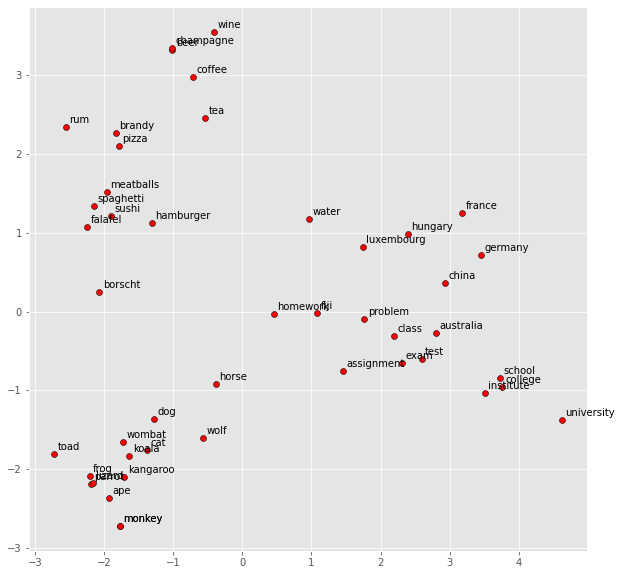

In [ ]:
display_pca_scatterplot(glove_model, 
                        ['coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'champagne', 'water',
                         'spaghetti', 'borscht', 'hamburger', 'pizza', 'falafel', 'sushi', 'meatballs',
                         'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
                         'frog', 'toad', 'monkey', 'ape', 'kangaroo', 'wombat', 'wolf',
                         'france', 'germany', 'hungary', 'luxembourg', 'australia', 'fiji', 'china',
                         'homework', 'assignment', 'problem', 'exam', 'test', 'class',
                         'school', 'college', 'university', 'institute'], pretrained=True)

# Classification with Word2vec

In [ ]:
# Document Representation

def doc2vec(doc):

  doc_vectors = []

  for w in doc.split():
    if w in model.wv.vocab:
      doc_vectors.append(model.wv[w])

  # Average word vectors
  return np.nanmean(np.array(doc_vectors), axis=0).tolist() if doc_vectors else np.zeros(100)

In [ ]:
# Get all category representations
cate2vec = dict()

for cate in cate2docs_train:
  cate_vectors = []
  for s in cate2docs_train[cate]:
    cate_vectors.append(doc2vec(s))

  cate2vec[cate] = np.nanmean(np.array(cate_vectors), axis=0).tolist()

In [ ]:
# predict

sample_cate = list_cate[0]
d = cate2docs_test[sample_cate][0]
print(sample_cate + '\n')

print(d)

doc_vector = doc2vec(d)

str = '\n\t{:17}'.format(' ')
for cate in list_cate:
    str += '{:15}'.format(cate)
print(str)
print('-'*800)
str = '{:21}'.format('!! cosine sim !! :')
for cate in list_cate:
    dist = cos_sim(doc_vector, cate2vec[cate])
    str += ('{:10.4f}{:5}'.format(dist, ' '))
print(str)
print('-'*800)

# predict result
cate2pred = dict()
for cate in list_cate:
  cate2pred[cate] = cos_sim(doc_vector, cate2vec[cate])
print('\n Predicted Class: ', sorted(list(cate2pred.items()), key = lambda x : x[1], reverse=True)[0])

ARTS

comedy tonight a popular show business axiom insists that dying is easy comedy is hard while any performer who has bombed onstage will quickly acknowledge this bitter truth the bottom line is that comedy depends on good ideas and solid execution

	                 ARTS           ARTS & CULTURE BLACK VOICES   BUSINESS       COLLEGE        COMEDY         CRIME          CULTURE & ARTS DIVORCE        EDUCATION      ENTERTAINMENT  ENVIRONMENT    FIFTY          FOOD & DRINK   GOOD NEWS      GREEN          HEALTHY LIVING HOME & LIVING  IMPACT         LATINO VOICES  MEDIA          MONEY          PARENTING      PARENTS        POLITICS       QUEER VOICES   RELIGION       SCIENCE        SPORTS         STYLE          STYLE & BEAUTY TASTE          TECH           TRAVEL         WEDDINGS       WEIRD NEWS     WELLNESS       WOMEN          WORLD NEWS     WORLDPOST      
--------------------------------------------------------------------------------------------------------------------------------

# RNN

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import SimpleRNN, Activation, Dense, Dropout, Input, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
%matplotlib inline

In [ ]:
df = pd.read_json('https://raw.githubusercontent.com/SoyeonHH/nlp/main/News_Category_Dataset_v2.json', lines=True)
df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

# using headlines and short_description as input X
df['text'] = df.headline + " " + df.short_description
df = df.drop(['headline', 'short_description'], axis=1)

df.head()

,category,authors,link,date,text
0,CRIME,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...
1,ENTERTAINMENT,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...
3,ENTERTAINMENT,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...


In [ ]:
cates = df.groupby('category')
list_cate = list(cates.size().to_dict().keys())

In [ ]:
# Process the data

## truncate data
df_trunc = pd.DataFrame(columns=['category', 'authors', 'link', 'date', 'text'])
for cate in list_cate:
  length = int(len(df[df['category'] == cate]) // 10)
  df_trunc = df_trunc.append(df[df['category'] == cate].iloc[:length, :], ignore_index=True)

## Create input and output vectors
X = df_trunc.text         ### X = df.text
Y_ = df_trunc.category    ### Y = df.category
le = LabelEncoder()
Y = le.fit_transform(Y_)
Y = Y.reshape(-1,1)

## Split into training and test data
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

## Make padded sequence matrix
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

## Convert integers to dummy variables (i.e. one hot encoded)
Y_train, Y_test = np_utils.to_categorical(Y_train), np_utils.to_categorical(Y_test)

In [ ]:
# Define the RNN structure

def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = SimpleRNN(128)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(40,name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:
rnn = RNN()
rnn.summary()
rnn.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 50)           50000     
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               22912     
                                                                 
 FC1 (Dense)                 (None, 256)               33024     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 40)                10280 

In [ ]:
# fit on the training data

rnn.fit(sequences_matrix,Y_train,batch_size=32,epochs=10)

In [ ]:
# model.save_weights('rnn_model.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/Shareddrives/kibme2022_nlp

rnn.load_weights('rnn_model.h5')

Mounted at /content/drive
/content/drive/Shareddrives/NLP


In [ ]:
rnn.load_weights('rnn_model.h5')

In [ ]:
# Process test set data
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_test)
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
accr = rnn.evaluate(test_sequences_matrix, Y_test)

95/95 [==============================] - 3s 27ms/step - loss: 3.3559 - accuracy: 0.1694


In [ ]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 3.356
  Accuracy: 0.169


In [ ]:
# predict

# predict on RNN
print('sample_cate: ' + Y_[0] + '\n')

d = X_test
print(list(d.values)[0])

doc_vector = rnn.predict(test_sequences_matrix)[0]

str = '\n\t{:17}'.format(' ')
for cate in list_cate:
    str += '{:15}'.format(cate)
print(str)
print('-'*800)
total = 0
str = '{:21}'.format('!! probability !! :')
for c in range(len(doc_vector)):
  str += ('{:10.4f}{:5}'.format(doc_vector[c], ' '))
  total += doc_vector[c]
print(str)
print('-'*800)
# print(total)

# predict result
cate2pred = dict()
for i, cate in enumerate(list_cate):
  cate2pred[cate] = doc_vector[i]
print('\n Predicted Class: ', sorted(list(cate2pred.items()), key = lambda x : x[1], reverse=True)[0])

sample_cate: ARTS

9 Democrats Sign Up To Help Wall Street Steal Cars They're backing a bill to undermine the Consumer Financial Protection Bureau.
95/95 [==============================] - 1s 11ms/step

	                 ARTS           ARTS & CULTURE BLACK VOICES   BUSINESS       COLLEGE        COMEDY         CRIME          CULTURE & ARTS DIVORCE        EDUCATION      ENTERTAINMENT  ENVIRONMENT    FIFTY          FOOD & DRINK   GOOD NEWS      GREEN          HEALTHY LIVING HOME & LIVING  IMPACT         LATINO VOICES  MEDIA          MONEY          PARENTING      PARENTS        POLITICS       QUEER VOICES   RELIGION       SCIENCE        SPORTS         STYLE          STYLE & BEAUTY TASTE          TECH           TRAVEL         WEDDINGS       WEIRD NEWS     WELLNESS       WOMEN          WORLD NEWS     WORLDPOST      
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# BERT

In [ ]:
!pip install transformers

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

from tabulate import tabulate
from tqdm import trange
import random

In [ ]:
# Prepare data
text = df_trunc.text     # text = df.text
Y = df_trunc.category    # Y = df.category
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)
labels = np_utils.to_categorical(Y)

print(labels.shape)

(20064, 40)


In [ ]:
# Preprcessing for bert
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True,
    # sep_token = '[SEP]',
    # pad_token = '[PAD]',
    # cls_token = '[CLS]',
    # mask_token = '[MASK]'
    )

### BERT preprocessing steps:

1. Add special tokens:

  - [CLS] : at the beginning of each sentences (ID 101)
  - [SEP] : at the end of each sentences (ID 102)

2. Make sentences of the same length:

  - This is achieved by padding, i.e. adding values of convenience to shorter sequences to match the desired length. Longer sequences are truncated.
  - The padding ([PAD]) tokens have ID 0.
  - The maximum sequence length allowed is of 512 tokens.

3. Create an attention mask:

  - List of 0/1 indicating whether the model should consider the tokens or not when learning their contextual representation. We expect [PAD] tokens to have value 0.

https://towardsdatascience.com/fine-tuning-bert-for-text-classification-54e7df642894

In [ ]:
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 32,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )


for sample in text:
  encoding_dict = preprocessing(sample, tokenizer)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
token_id[6]

tensor([  101,  2754,  2341,  1024, 10346,  2937,  1005,  1055, 10098,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [ ]:
def print_rand_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of a random text sample'''
  # index = random.randint(0, len(text) - 1)
  tokens = tokenizer.tokenize(tokenizer.decode(token_id[6]))
  token_ids = [i.numpy() for i in token_id[6]]
  attention = [i.numpy() for i in attention_masks[6]]

  table = np.array([tokens, token_ids, attention]).T
  print(tabulate(table, 
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence_encoding()

╒══════════╤═════════════╤══════════════════╕
│ Tokens   │   Token IDs │   Attention Mask │
╞══════════╪═════════════╪══════════════════╡
│ [CLS]    │         101 │                1 │
├──────────┼─────────────┼──────────────────┤
│ stage    │        2754 │                1 │
├──────────┼─────────────┼──────────────────┤
│ door     │        2341 │                1 │
├──────────┼─────────────┼──────────────────┤
│ :        │        1024 │                1 │
├──────────┼─────────────┼──────────────────┤
│ fin      │       10346 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ##ian    │        2937 │                1 │
├──────────┼─────────────┼──────────────────┤
│ '        │        1005 │                1 │
├──────────┼─────────────┼──────────────────┤
│ s        │        1055 │                1 │
├──────────┼─────────────┼──────────────────┤
│ rainbow  │       10098 │                1 │
├──────────┼─────────────┼──────────────────┤
│ [SEP]    │         102 │        

In [ ]:
# Data split

val_ratio = 0.2
batch_size = 16

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = val_ratio,
    shuffle = True,
    stratify = labels)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )

## Training

In [ ]:
# Bert pretraining

# bert_model = huggingface.BERT(
#     vocab_size=args.vocab_size,
#     num_hidden_layers=args.num_hidden_layers,
#     hidden_size=args.hidden_size,
#     num_attention_heads=args.num_attention_heads,
#     intermediate_size=args.intermediate_size,
#     max_position_embeddings=args.max_seq_length,
#     hidden_act=args.hidden_act)

## Fine-tuning

In [ ]:
# Load the BertForSequenceClassification model
bert = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 40,
    output_attentions = False,
    output_hidden_states = True,
)

optimizer = torch.optim.AdamW(bert.parameters(), lr = 5e-5, eps = 1e-08)

# Run on GPU
bert.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Perform the training procedure !

epochs = 2

for _ in trange(epochs, desc = 'Epoch'):
    
    # ========== Training ==========
    
    # Set model to training mode
    bert.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = bert(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1



Epoch: 100%|██████████| 2/2 [04:04<00:00, 122.31s/it]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/Shareddrives/kibme2022_nlp

# torch.save(bert.state_dict(), './bert.pt')

bert.load_state_dict(torch.load('bert.pt'))
bert.eval()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shareddrives/NLP


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# predict

# predict on BERT

sample_cate = list_cate[0]
d = cate2docs_test[sample_cate][0]
print(sample_cate + '\n')

print(d)

# We need Token IDs and Attention Mask for inference on the new sentence
test_ids = []
test_attention_mask = []

# Apply the tokenizer
encoding = preprocessing(d, tokenizer)

# Extract IDs and Attention Mask
test_ids.append(encoding['input_ids'])
test_attention_mask.append(encoding['attention_mask'])
test_ids = torch.cat(test_ids, dim = 0)
test_attention_mask = torch.cat(test_attention_mask, dim = 0)

# Forward pass, calculate logit predictions
with torch.no_grad():
  outputs = bert(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

doc_vector = outputs.logits[0]

str = '\n\t{:17}'.format(' ')
for cate in list_cate:
    str += '{:15}'.format(cate)
print(str)
print('-'*800)
str = '{:21}'.format('!! score !! :')
for c in range(len(doc_vector)):
  str += ('{:10.4f}{:5}'.format(doc_vector[c], ' '))
print(str)
print('-'*800)

# predict result
cate2pred = dict()
for i, cate in enumerate(list_cate):
  cate2pred[cate] = doc_vector[i]
print('\n Predicted Class: ', sorted(list(cate2pred.items()), key = lambda x : x[1], reverse=True)[0])


ARTS

comedy tonight a popular show business axiom insists that dying is easy comedy is hard while any performer who has bombed onstage will quickly acknowledge this bitter truth the bottom line is that comedy depends on good ideas and solid execution

	                 ARTS           ARTS & CULTURE BLACK VOICES   BUSINESS       COLLEGE        COMEDY         CRIME          CULTURE & ARTS DIVORCE        EDUCATION      ENTERTAINMENT  ENVIRONMENT    FIFTY          FOOD & DRINK   GOOD NEWS      GREEN          HEALTHY LIVING HOME & LIVING  IMPACT         LATINO VOICES  MEDIA          MONEY          PARENTING      PARENTS        POLITICS       QUEER VOICES   RELIGION       SCIENCE        SPORTS         STYLE          STYLE & BEAUTY TASTE          TECH           TRAVEL         WEDDINGS       WEIRD NEWS     WELLNESS       WOMEN          WORLD NEWS     WORLDPOST      
--------------------------------------------------------------------------------------------------------------------------------